$\textbf{Part a: Ordinary Least Squares (OLS) for the Runge function}$

-> Runges function: f(x) = 1 / ( 1 + 25x^2), x in [-1, 1]

* Create dataset for f(x)
* Add stochastic noise

* Perform standard OLS regression using polynomials in x up to order 15 or higher 
* Explore the dependence on the number of data points and the polynomial degree

* Evaluate MSE and the $R^2$ score function 

* Plot MSE and $R^2$ as functions of polynomial degree 
* Plot also the parameters $\theta$ as you increase order of polynomial 

Has to include:
* Scaling/centering of data 
* Split of the data in training and test 

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

np.random.seed(73)

In [20]:
def polynomial_features(x, p, intercept=False):
    n = len(x)
    if intercept:
        X = np.zeros((n, p+1))
        X[:, 0] = 1   # intercept-kolonnen
        for i in range(1, p+1):   
            X[:, i] = x**i
    else:
        X = np.zeros((n, p))
        for i in range(p):
            X[:, i] = x**(i+1)
    return X

In [21]:
datapoints = [100, 1000, 10000, 100000]
poly = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [22]:
results_ols = {}

rng = np.random.default_rng(73) #random number generator med random seed = 73

for n in datapoints:
    
    x = np.linspace(-1,1,n)
    y = 1 / (1 + 25*x**2)
    #noise = 0.5 * np.random.randn(n)    # Gaussian (normal distribution) noise
    #y = y + noise

    noise = 0.5 * rng.standard_normal(n)

    y = y + noise 

    #Make one index-split per n, and reuse for all p
    idx = np.arange(n)
    idx_train, idx_test = train_test_split(idx, test_size=0.2, random_state=73)


    for p in poly:
        
        Xp = polynomial_features(x, p, intercept=False)

        #use the same indexes for Xp and y
        X_train = Xp[idx_train, :]
        X_test = Xp[idx_test, :]
        y_train = y[idx_train]
        y_test = y[idx_test]

        #scale only on train, and then use the same scaler for test 
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train_s = scaler.transform(X_train)
        X_test_s = scaler.transform(X_test)

        #center y with train mean (and same offset on test)
        y_offset = np.mean(y_train)
        y_train_s = y_train - y_offset
        y_test_s = y_test - y_offset

        #calculate theta
        theta = np.linalg.pinv(X_train_s) @ y_train_s #more stable even when X^TX er dårlig kondisjonert eller p er stor

        #predicting y with the model (with sentered y)
        y_hat_train_sc = X_train_s @ theta
        y_hat_test_sc = X_test_s @ theta

        #unnormalising y - to be on the same scale as the original y values 
        #y_hat_train = y_hat_train_sc + y_offset
        #y_hat_test = y_hat_test_sc + y_offset

        #calculate MSE 
        mse_train = np.mean((y_train_s - y_hat_train_sc)**2)
        mse_test = np.mean((y_test_s - y_hat_test_sc)**2)

        #calculate R^2
        SSE_tr = np.sum((y_train_s - y_hat_train_sc)**2)
        SST_tr = np.sum((y_train_s - y_train_s.mean())**2)
        #SST_tr = np.sum(y_train_s**2)
        R2_train = 1 - SSE_tr / SST_tr

        SSE_te = np.sum((y_test_s - y_hat_test_sc)**2)
        SST_te = np.sum((y_test_s - y_train_s.mean())**2)
        #SST_te = np.sum(y_test_s**2)
        R2_test = 1 - SSE_te / SST_te

        #sjekke stabilitet 

        theta_norm = np.linalg.norm(theta)

        results_ols[(n, p)] = {
            #train, test, scaler values
            "X_train": X_train_s, "X_test": X_test_s,
            "y_train": y_train_s, "y_test": y_test_s,
            "scaler_mean": scaler.mean_, "scaler_scale": scaler.scale_,
            "y_offset": y_offset,
            #index and x values
            "idx_train": idx_train, "idx_test": idx_test,
            "x_train": x[idx_train], "x_test": x[idx_test],
            #theta, mse and R^2 values
            "theta": theta, 
            "mse_train": mse_train, "mse_test": mse_test,
            "R2_train": R2_train, "R2_test": R2_test, 
            #theta norm 
            "theta_norm": theta_norm,
        }


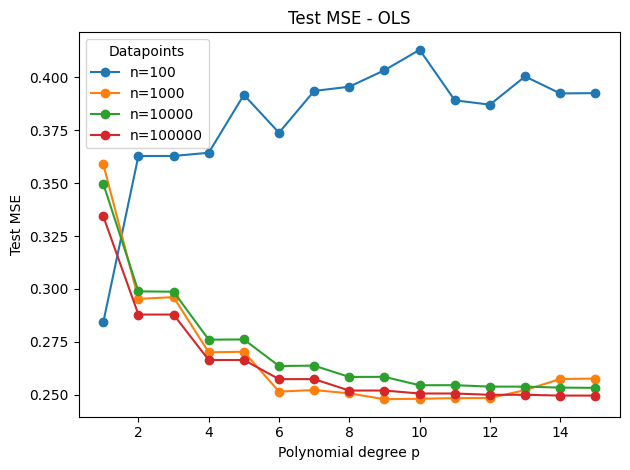

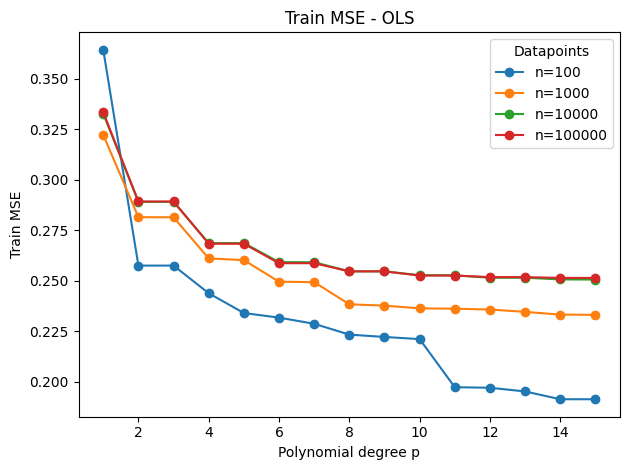

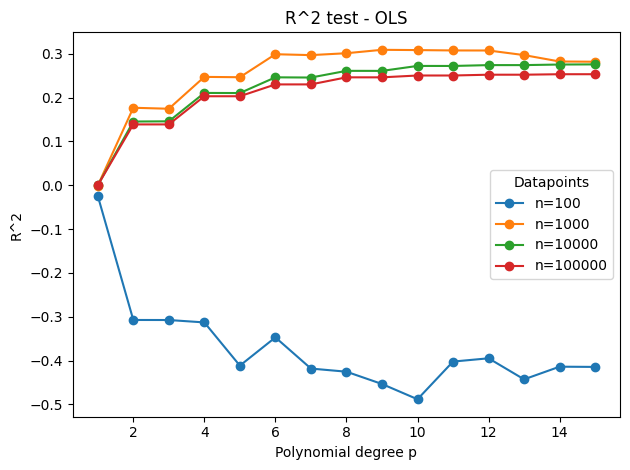

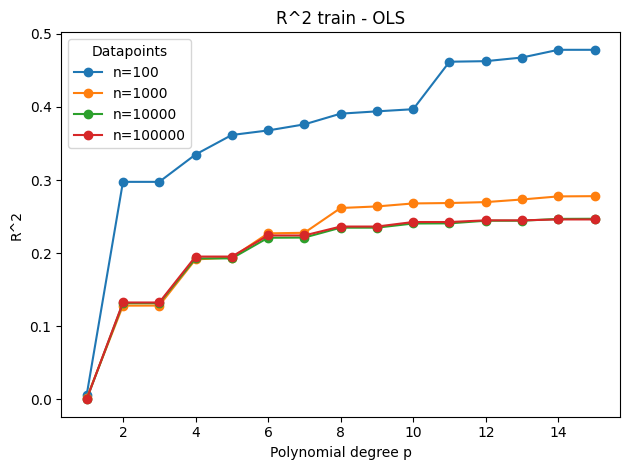

In [23]:
#plotting for a)

#plot MSE test
ns = sorted({n for (n, _) in results_ols.keys()})
plt.figure()
for n_focus in ns:
    ps = sorted({p for (n_key, p) in results_ols.keys() if n_key == n_focus})
    mse_te_ols = [results_ols[(n_focus, p)]["mse_test"] for p in ps]
    plt.plot(ps, mse_te_ols, marker="o", label=f"n={n_focus}")
plt.title("Test MSE - OLS")
plt.xlabel("Polynomial degree p")
plt.ylabel("Test MSE")
plt.legend(title="Datapoints")
plt.tight_layout()
#plt.show()

#plot MSE train
ns = sorted({n for (n, _) in results_ols.keys()})
plt.figure()
for n_focus in ns:
    ps = sorted({p for (n_key, p) in results_ols.keys() if n_key == n_focus})
    mse_tr_ols = [results_ols[(n_focus, p)]["mse_train"] for p in ps]
    plt.plot(ps, mse_tr_ols, marker="o", label=f"n={n_focus}")
plt.title("Train MSE - OLS")
plt.xlabel("Polynomial degree p")
plt.ylabel("Train MSE")
plt.legend(title="Datapoints")
plt.tight_layout()
#plt.show()

#plot R^2 test
ns = sorted({n for (n, _) in results_ols.keys()})
plt.figure()
for n_focus in ns:
    ps = sorted({p for (n_key, p) in results_ols.keys() if n_key == n_focus})
    R2_te_ols = [results_ols[(n_focus, p)]["R2_test"] for p in ps]
    plt.plot(ps, R2_te_ols, marker="o", label=f"n={n_focus}")
plt.title("R^2 test - OLS")
plt.xlabel("Polynomial degree p")
plt.ylabel("R^2")
plt.legend(title="Datapoints")
plt.tight_layout()
#plt.show()

#plot R^2 train
ns = sorted({n for (n, _) in results_ols.keys()})
plt.figure()
for n_focus in ns:
    ps = sorted({p for (n_key, p) in results_ols.keys() if n_key == n_focus})
    R2_tr_ols = [results_ols[(n_focus, p)]["R2_train"] for p in ps]
    plt.plot(ps, R2_tr_ols, marker="o", label=f"n={n_focus}")
plt.title("R^2 train - OLS")
plt.xlabel("Polynomial degree p")
plt.ylabel("R^2")
plt.legend(title="Datapoints")
plt.tight_layout()
#plt.show()

#plot theta
#må finne ut hva beste måte for det er 

Test-MSE:
* For små n, (n = 100), blir test-MSE større når p blir større, $\to$ overfitting (eller mer varians?)
* For større n (n = 1000, 10000, 100000) faller MSE når p øker og flater ut, rundt 0.25 (nær støyvariansen). Dette er den irreducerbare feilen: selv med en perfekt modell kan vi ikke komme mye under  $\sigma^2$ i forventning.

* $\sigma^2 = (0.5)^2 = 0.25$. 

Train-MSE

$\textbf{Part b: Adding Ridge regression for the Runge function}$

In [24]:
def Ridge_parameters(X, y, lam):
    # Assumes X is scaled and has no intercept column
    n, p = X.shape
    I = np.eye(p)
    return np.linalg.inv(X.T @ X + lam* I) @ X.T @ y

lams = [0.0] + list(np.logspace(-6, 3, 20))  # 1e-6 ... 1e3

In [25]:
results_ridge = {}

rng = np.random.default_rng(73) #random number generator med random seed = 73

for n in datapoints:
    
    x = np.linspace(-1,1,n)
    y = 1 / (1 + 25*x**2)
    #noise = 0.5 * np.random.randn(n)    # Gaussian (normal distribution) noise
    #y = y + noise

    noise = 0.5 * rng.standard_normal(n)

    y = y + noise 

    #Make one index-split per n, and reuse for all p
    idx = np.arange(n)
    idx_train, idx_test = train_test_split(idx, test_size=0.2, random_state=73)


    for p in poly:
        
        Xp = polynomial_features(x, p, intercept=False)

        #use the same indexes for Xp and y
        X_train = Xp[idx_train, :]
        X_test = Xp[idx_test, :]
        y_train = y[idx_train]
        y_test = y[idx_test]

        #scale only on train, and then use the same scaler for test 
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train_s = scaler.transform(X_train)
        X_test_s = scaler.transform(X_test)

        #center y with train mean (and same offset on test)
        y_offset = np.mean(y_train)
        y_train_s = y_train - y_offset
        y_test_s = y_test - y_offset

        for lam in lams:
            theta = Ridge_parameters(X_train_s, y_train_s, lam)

            #predicting y with the model (with sentered y)
            y_hat_train_sc = X_train_s @ theta
            y_hat_test_sc = X_test_s @ theta

            #calculate MSE 
            mse_train = np.mean((y_train_s - y_hat_train_sc)**2)
            mse_test = np.mean((y_test_s - y_hat_test_sc)**2)

            #calculate R^2
            SSE_tr = np.sum((y_train_s - y_hat_train_sc)**2)
            SST_tr = np.sum((y_train_s - y_train_s.mean())**2)
            #SST_tr = np.sum(y_train_s**2)
            R2_train = 1 - SSE_tr / SST_tr

            SSE_te = np.sum((y_test_s - y_hat_test_sc)**2)
            SST_te = np.sum((y_test_s - y_train_s.mean())**2)
            #SST_te = np.sum(y_test_s**2)
            R2_test = 1 - SSE_te / SST_te

            #sjekke stabilitet 

            theta_norm = np.linalg.norm(theta)

            # ---------- LAGRE PER (n, p, modell, lam) ----------
            key = (n, p, "ridge", float(lam))
            results_ridge[key] = {
            "theta": theta,
            "theta_norm": theta_norm,
            "mse_train": mse_train, "mse_test": mse_test,
            "R2_train": R2_train,   "R2_test": R2_test,
            "lam": float(lam), "reg_label": "ridge",
            "scaler_mean": scaler.mean_, "scaler_scale": scaler.scale_,
            "y_offset": y_offset,
            "idx_train": idx_train, "idx_test": idx_test,
            "x_train": x[idx_train], "x_test": x[idx_test],
        }


In [26]:
#plotting for b)

"""

#plot MSE test
ns = sorted({n for (n, _) in results_ridge.keys()})
plt.figure()
for n_focus in ns:
    ps = sorted({p for (n_key, p) in results_ridge.keys() if n_key == n_focus})
    mse_te_ridge = [results_ridge[(n_focus, p)]["mse_test"] for p in ps]
    plt.plot(ps, mse_te_ridge, marker="o", label=f"n={n_focus}")
plt.title("Test MSE - Ridge")
plt.xlabel("Polynomial degree p")
plt.ylabel("Test MSE")
plt.legend(title="Datapoints")
plt.tight_layout()
plt.show()

#plot MSE train
ns = sorted({n for (n, _) in results_ridge.keys()})
plt.figure()
for n_focus in ns:
    ps = sorted({p for (n_key, p) in results_ridge.keys() if n_key == n_focus})
    mse_tr_ridge = [results_ridge[(n_focus, p)]["mse_train"] for p in ps]
    plt.plot(ps, mse_tr_ridge, marker="o", label=f"n={n_focus}")
plt.title("Train MSE - Ridge")
plt.xlabel("Polynomial degree p")
plt.ylabel("Train MSE")
plt.legend(title="Datapoints")
plt.tight_layout()
plt.show()

#plot R^2 test
ns = sorted({n for (n, _) in results_ridge.keys()})
plt.figure()
for n_focus in ns:
    ps = sorted({p for (n_key, p) in results_ridge.keys() if n_key == n_focus})
    R2_te_ridge = [results_ridge[(n_focus, p)]["R2_test"] for p in ps]
    plt.plot(ps, R2_te_ridge, marker="o", label=f"n={n_focus}")
plt.title("R^2 test - Ridge")
plt.xlabel("Polynomial degree p")
plt.ylabel("R^2")
plt.legend(title="Datapoints")
plt.tight_layout()
plt.show()

#plot R^2 train
ns = sorted({n for (n, _) in results_ridge.keys()})
plt.figure()
for n_focus in ns:
    ps = sorted({p for (n_key, p) in results_ridge.keys() if n_key == n_focus})
    R2_tr_ridge = [results_ridge[(n_focus, p)]["R2_train"] for p in ps]
    plt.plot(ps, R2_tr_ridge, marker="o", label=f"n={n_focus}")
plt.title("R^2 train - Ridge")
plt.xlabel("Polynomial degree p")
plt.ylabel("R^2")
plt.legend(title="Datapoints")
plt.tight_layout()
plt.show()

#plot theta
#må finne ut hva beste måte for det er 

"""

'\n\n#plot MSE test\nns = sorted({n for (n, _) in results_ridge.keys()})\nplt.figure()\nfor n_focus in ns:\n    ps = sorted({p for (n_key, p) in results_ridge.keys() if n_key == n_focus})\n    mse_te_ridge = [results_ridge[(n_focus, p)]["mse_test"] for p in ps]\n    plt.plot(ps, mse_te_ridge, marker="o", label=f"n={n_focus}")\nplt.title("Test MSE - Ridge")\nplt.xlabel("Polynomial degree p")\nplt.ylabel("Test MSE")\nplt.legend(title="Datapoints")\nplt.tight_layout()\nplt.show()\n\n#plot MSE train\nns = sorted({n for (n, _) in results_ridge.keys()})\nplt.figure()\nfor n_focus in ns:\n    ps = sorted({p for (n_key, p) in results_ridge.keys() if n_key == n_focus})\n    mse_tr_ridge = [results_ridge[(n_focus, p)]["mse_train"] for p in ps]\n    plt.plot(ps, mse_tr_ridge, marker="o", label=f"n={n_focus}")\nplt.title("Train MSE - Ridge")\nplt.xlabel("Polynomial degree p")\nplt.ylabel("Train MSE")\nplt.legend(title="Datapoints")\nplt.tight_layout()\nplt.show()\n\n#plot R^2 test\nns = sorted({n 

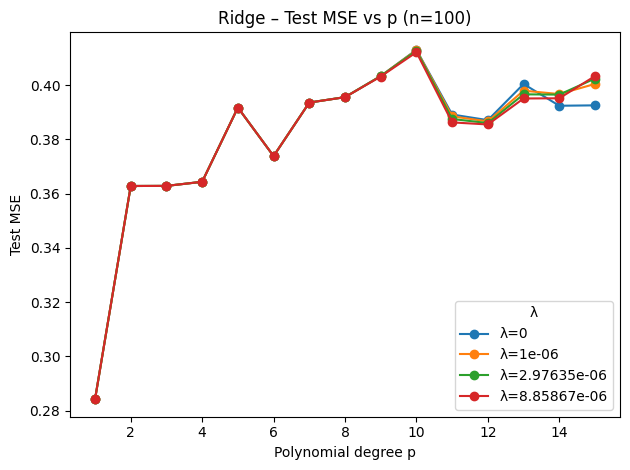

In [27]:
n_focus = ns[0]  # velg ett n

plt.figure()
for lam_focus in lams[:4]:  # f.eks. første 4 λ-verdier
    ps_n = sorted(p for (n, p, model, lam) in results_ridge
                  if n == n_focus and model == "ridge" and lam == lam_focus)
    mse_te = [results_ridge[(n_focus, p, "ridge", lam_focus)]["mse_test"] for p in ps_n]
    plt.plot(ps_n, mse_te, marker="o", label=f"λ={lam_focus:g}")
plt.title(f"Ridge – Test MSE vs p (n={n_focus})")
plt.xlabel("Polynomial degree p"); plt.ylabel("Test MSE")
plt.legend(title="λ"); plt.tight_layout(); plt.show()

In [28]:
#chat

# Plukk ut unike verdier av n, p, lam fra results_ridge
Ns_ridge   = sorted({k[0] for k in results_ridge.keys()})
Ps_ridge   = sorted({k[1] for k in results_ridge.keys()})
LAMs_all   = sorted({k[3] for k in results_ridge.keys()})

# Velg et ryddig delsett av lambdas for plotting over p
# (juster gjerne lista hvis du har andre lam i lams)
target_lams = [0.0, 1e-6, 1e-4, 1e-2, 1e0, 1e2]
def nearest_lam(target, lam_list):
    return min(lam_list, key=lambda z: abs(z - target))

LAMs_subset = []
for t in target_lams:
    if len(LAMs_all) == 0: break
    LAMs_subset.append(nearest_lam(t, LAMs_all))
# fjern ev. duplikater
LAMs_subset = sorted({float(x) for x in LAMs_subset})

def get_ridge_metric(n, p, lam, metric):
    return results_ridge[(n, p, "ridge", float(lam))][metric]

def get_ols_metric(n, p, metric):
    return results_ols[(n, p)][metric]

1) Sammenlign Ridge (utvalgte λ) vs OLS: MSE_test og R²_test som funksjon av p, for hver n

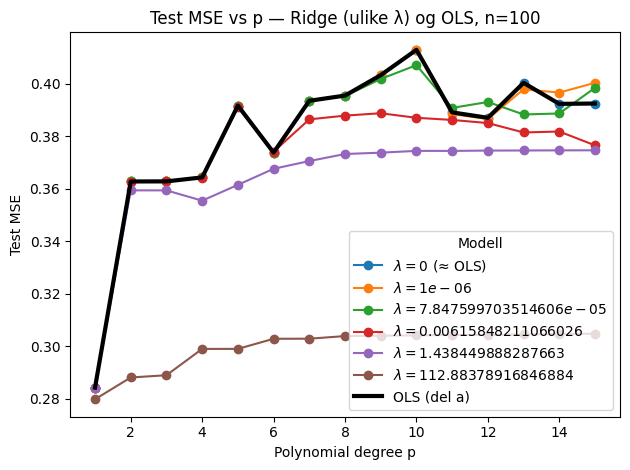

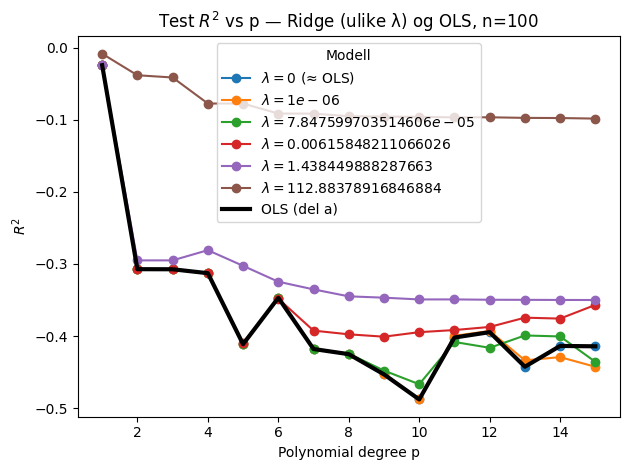

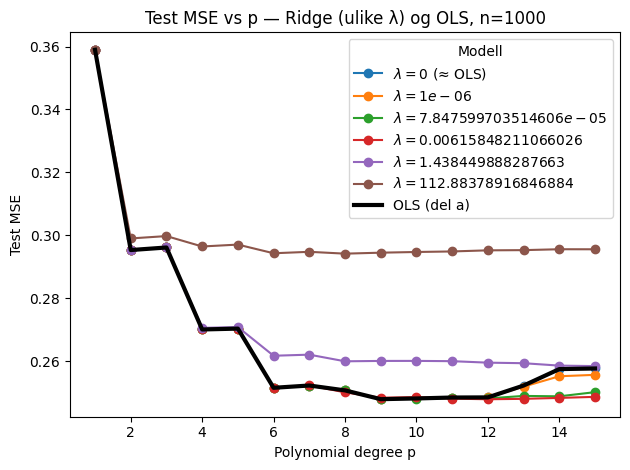

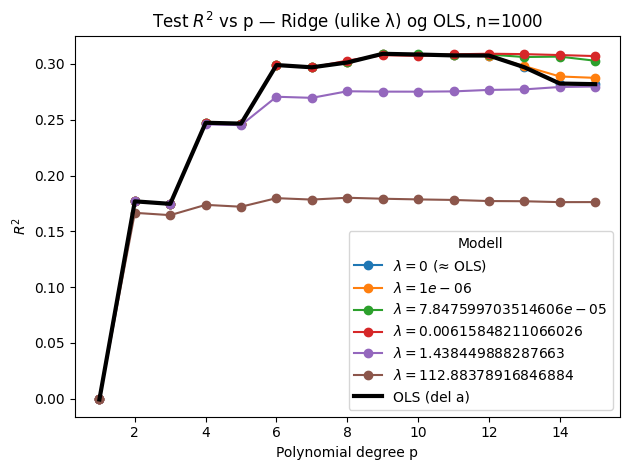

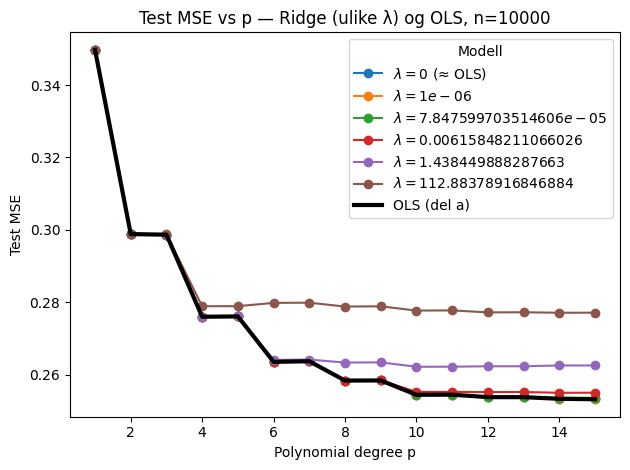

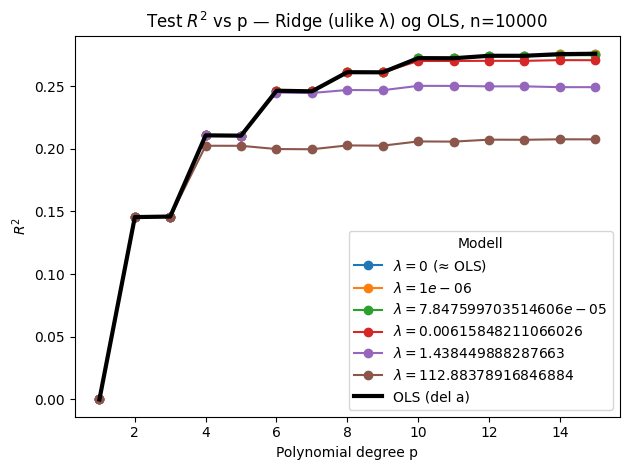

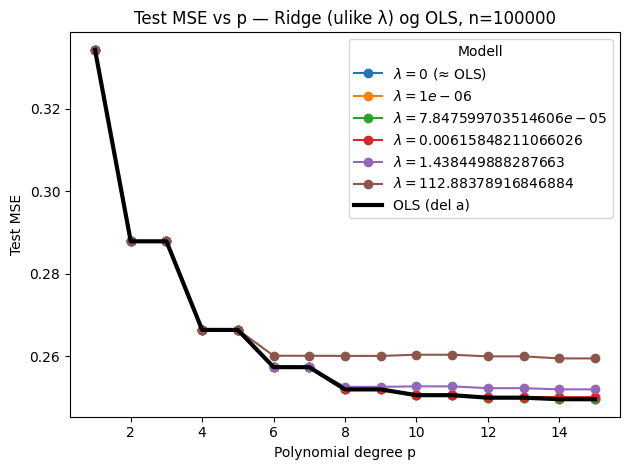

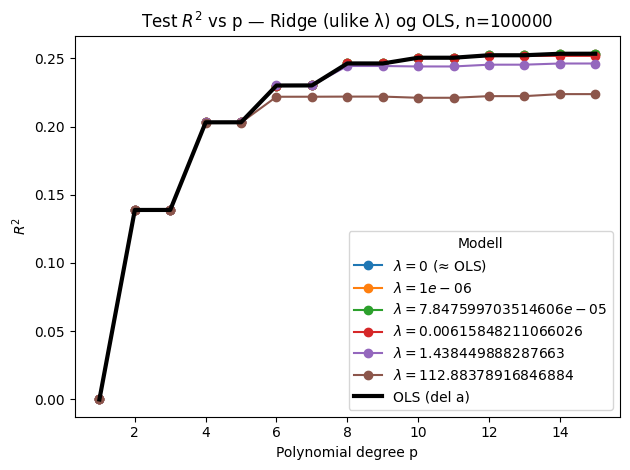

In [29]:
for n_focus in Ns_ridge:
    ps = sorted({k[1] for k in results_ridge.keys() if k[0] == n_focus})
    
    # --- Test MSE ---
    plt.figure()
    for lam in LAMs_subset:
        mse_te = [get_ridge_metric(n_focus, p, lam, "mse_test") for p in ps]
        lab = r"$\lambda={}$".format(lam) if lam != 0 else r"$\lambda=0$ (≈ OLS)"
        plt.plot(ps, mse_te, marker="o", label=lab)
    
    # Legg på OLS (din del a) ) som svart, tykk linje
    mse_te_ols = [get_ols_metric(n_focus, p, "mse_test") for p in ps]
    plt.plot(ps, mse_te_ols, linewidth=3, label="OLS (del a)", color="black")
    
    plt.title(f"Test MSE vs p — Ridge (ulike λ) og OLS, n={n_focus}")
    plt.xlabel("Polynomial degree p"); plt.ylabel("Test MSE")
    plt.legend(title="Modell"); plt.tight_layout(); plt.show()
    
    # --- Test R^2 ---
    plt.figure()
    for lam in LAMs_subset:
        r2_te = [get_ridge_metric(n_focus, p, lam, "R2_test") for p in ps]
        lab = r"$\lambda={}$".format(lam) if lam != 0 else r"$\lambda=0$ (≈ OLS)"
        plt.plot(ps, r2_te, marker="o", label=lab)
    
    r2_te_ols = [get_ols_metric(n_focus, p, "R2_test") for p in ps]
    plt.plot(ps, r2_te_ols, linewidth=3, label="OLS (del a)", color="black")
    
    plt.title(f"Test $R^2$ vs p — Ridge (ulike λ) og OLS, n={n_focus}")
    plt.xlabel("Polynomial degree p"); plt.ylabel(r"$R^2$")
    plt.legend(title="Modell"); plt.tight_layout(); plt.show()


2) Studér avhengighet av λ direkte: MSE_test og R²_test som funksjon av λ (logskala), for noen utvalgte p (per n)

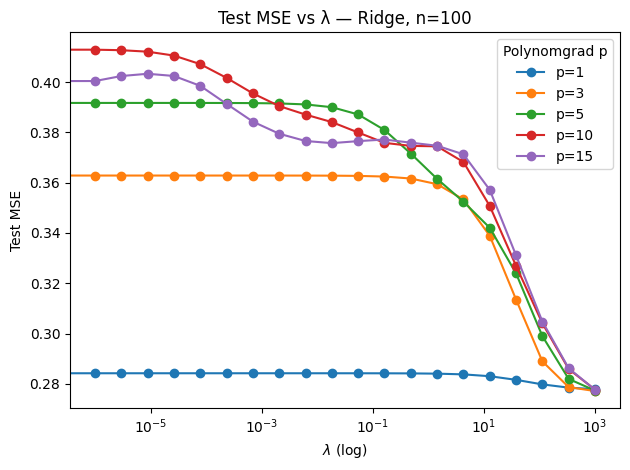

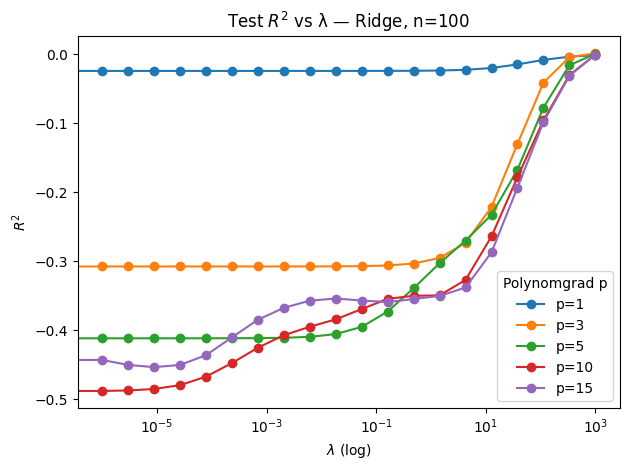

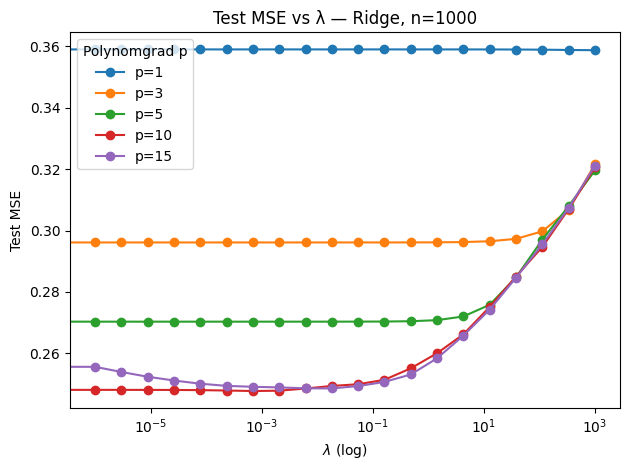

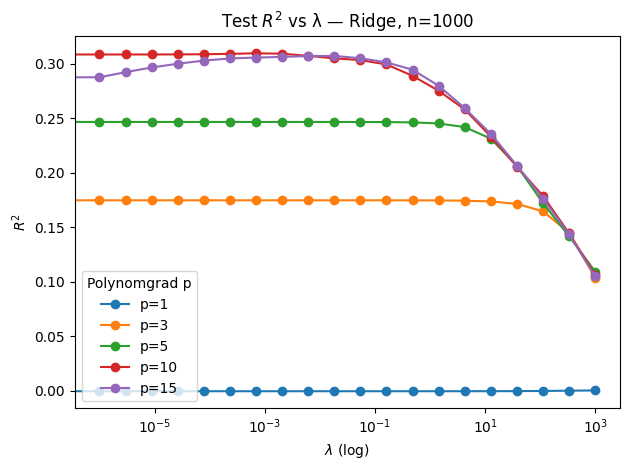

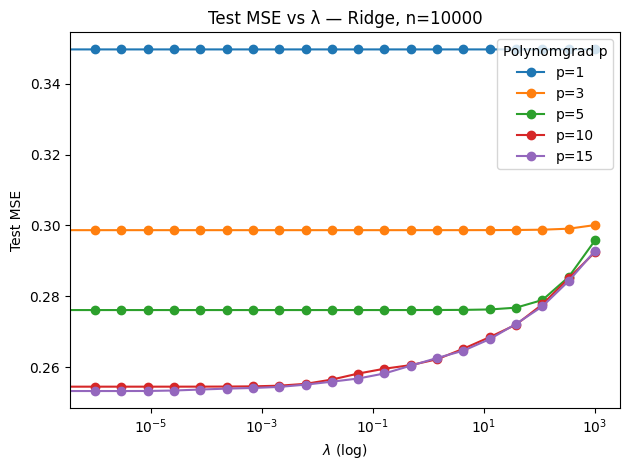

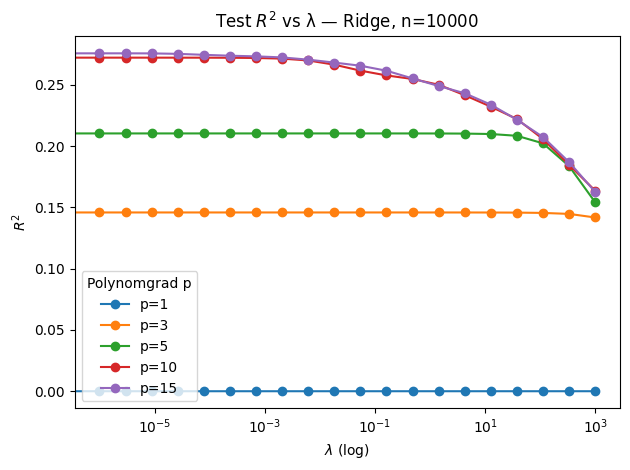

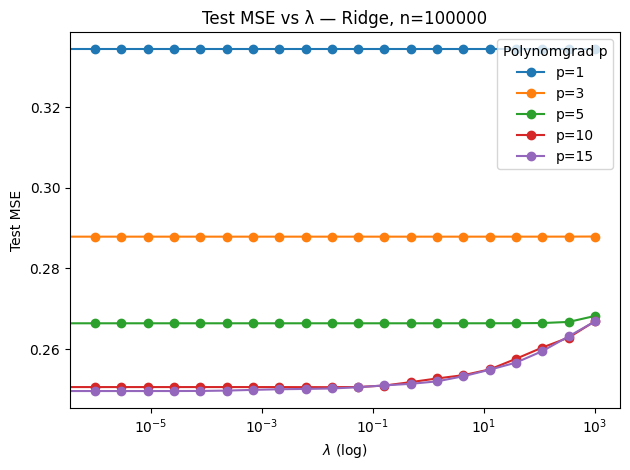

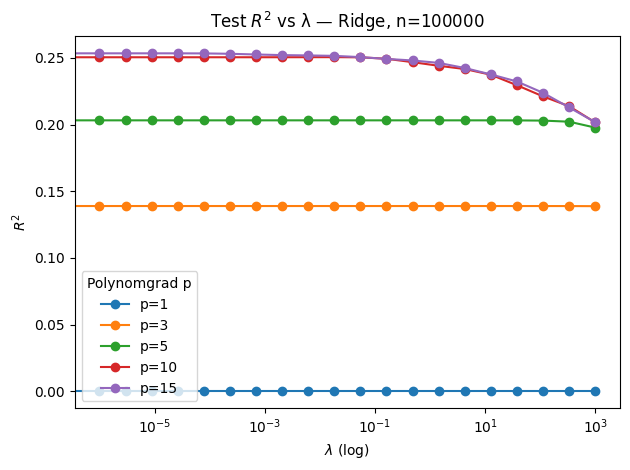

In [30]:
p_subset_candidates = [1, 3, 5, 10, 15]
for n_focus in Ns_ridge:
    ps_available = sorted({k[1] for k in results_ridge.keys() if k[0]==n_focus})
    p_subset = [p for p in p_subset_candidates if p in ps_available]
    if not p_subset: 
        continue
    
    # --- Test MSE vs lambda ---
    plt.figure()
    for p in p_subset:
        lam_list = sorted({k[3] for k in results_ridge.keys() if k[0]==n_focus and k[1]==p})
        mse_te = [get_ridge_metric(n_focus, p, lam, "mse_test") for lam in lam_list]
        plt.semilogx(lam_list, mse_te, marker="o", label=f"p={p}")
    
    plt.title(f"Test MSE vs λ — Ridge, n={n_focus}")
    plt.xlabel(r"$\lambda$ (log)"); plt.ylabel("Test MSE")
    plt.legend(title="Polynomgrad p"); plt.tight_layout(); plt.show()
    
    # --- Test R^2 vs lambda ---
    plt.figure()
    for p in p_subset:
        lam_list = sorted({k[3] for k in results_ridge.keys() if k[0]==n_focus and k[1]==p})
        r2_te = [get_ridge_metric(n_focus, p, lam, "R2_test") for lam in lam_list]
        plt.semilogx(lam_list, r2_te, marker="o", label=f"p={p}")
    
    plt.title(f"Test $R^2$ vs λ — Ridge, n={n_focus}")
    plt.xlabel(r"$\lambda$ (log)"); plt.ylabel(r"$R^2$")
    plt.legend(title="Polynomgrad p"); plt.tight_layout(); plt.show()


Tips til drøfting (når du ser figurene)

OLS-kurven (λ=0) vil ofte dyppe og så stige for test-MSE når p blir stor (overtilpasning).

For moderate/høye p vil en moderat λ gi lavere test-MSE (bedre generalisering).

R² speiler dette: høyere R² for test ved passende λ, særlig ved større p.

Heatmap gjør det lett å peke ut “beste område” (lav MSE) i (p, λ)-planet for hvert n.

Rop ut om du vil at jeg skal legge inn tilsvarende plott for train også, eller plotte ‖θ‖ (koeffisientnorm) mot p/λ for å vise stabilisering fra regulærisering.

$\textbf{Part c: Writing your own gradient descent code}$

In [31]:
def gd_fit(X, y, eta=0.1, num_iters=1000, lam=0.0, theta0=None, record_every=10):
    """
    X: skalert design (n x p), uten intercept-kolonne
    y: senterert target (n,)
    eta: learning rate (fast)
    num_iters: antall iterasjoner
    lam: ridge-lambda (0 => OLS)
    theta0: initialisering (p,). Hvis None: zeros.
    record_every: hvor ofte vi lagrer MSE i historikk
    """
    n, p = X.shape
    theta = np.zeros(p) if theta0 is None else theta0.copy()

    hist = {"iter": [], "mse": []}
    for t in range(1, num_iters+1):
        # grad for OLS: (2/n) X^T (Xθ - y)
        # Ridge: legg til 2λθ
        residual = X @ theta - y
        grad = (2.0/n) * (X.T @ residual) + 2.0 * lam * theta

        theta -= eta * grad

        if (t % record_every) == 0 or t == 1 or t == num_iters:
            mse = np.mean(residual**2)
            hist["iter"].append(t)
            hist["mse"].append(mse)

    return theta, hist

In [36]:
eta = 0.1

num_iters = 2000 

n_features = 2

lam = 0.1

In [34]:
# OLS 

results_gd_ols = {}

rng = np.random.default_rng(73) #random number generator med random seed = 73

for n in datapoints:
    
    x = np.linspace(-1,1,n)
    y = 1 / (1 + 25*x**2)
    #noise = 0.5 * np.random.randn(n)    # Gaussian (normal distribution) noise
    #y = y + noise

    noise = 0.5 * rng.standard_normal(n)

    y = y + noise 

    #Make one index-split per n, and reuse for all p
    idx = np.arange(n)
    idx_train, idx_test = train_test_split(idx, test_size=0.2, random_state=73)


    for p in poly:
        
        Xp = polynomial_features(x, p, intercept=False)

        #use the same indexes for Xp and y
        X_train = Xp[idx_train, :]
        X_test = Xp[idx_test, :]
        y_train = y[idx_train]
        y_test = y[idx_test]

        #scale only on train, and then use the same scaler for test 
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train_s = scaler.transform(X_train)
        X_test_s = scaler.transform(X_test)

        #center y with train mean (and same offset on test)
        y_offset = np.mean(y_train)
        y_train_s = y_train - y_offset
        y_test_s = y_test - y_offset

            #for eta in etas:

        # Gradient descent loop

        theta_gdOLS = np.zeros(X_train_s.shape[1])

        for t in range(num_iters):
            # Compute gradients for OSL 
            grad_OLS = (2 / len(y_train_s)) * (X_train_s.T @ (X_train_s @ theta_gdOLS - y_train_s))
            # Update parameters theta
            theta_gdOLS = theta_gdOLS - eta * grad_OLS

            #predicting y with the model (with sentered y)
            y_hat_train_sc = X_train_s @ theta_gdOLS
            y_hat_test_sc = X_test_s @ theta_gdOLS

            #unnormalising y - to be on the same scale as the original y values 
            #y_hat_train = y_hat_train_sc + y_offset
            #y_hat_test = y_hat_test_sc + y_offset

            #calculate MSE 
            mse_train = np.mean((y_train_s - y_hat_train_sc)**2)
            mse_test = np.mean((y_test_s - y_hat_test_sc)**2)

            #calculate R^2
            SSE_tr = np.sum((y_train_s - y_hat_train_sc)**2)
            SST_tr = np.sum((y_train_s - y_train_s.mean())**2)
            #SST_tr = np.sum(y_train_s**2)
            R2_train = 1 - SSE_tr / SST_tr

            SSE_te = np.sum((y_test_s - y_hat_test_sc)**2)
            SST_te = np.sum((y_test_s - y_train_s.mean())**2)
            #SST_te = np.sum(y_test_s**2)
            R2_test = 1 - SSE_te / SST_te

        results_gd_ols[(n, p)] = {
            #train, test, scaler values
            "X_train": X_train_s, "X_test": X_test_s,
            "y_train": y_train_s, "y_test": y_test_s,
            "scaler_mean": scaler.mean_, "scaler_scale": scaler.scale_,
            "y_offset": y_offset,
            #index and x values
            "idx_train": idx_train, "idx_test": idx_test,
            "x_train": x[idx_train], "x_test": x[idx_test],
            #theta, mse and R^2 values
            "theta": theta_gdOLS, 
            "mse_train": mse_train, "mse_test": mse_test,
            "R2_train": R2_train, "R2_test": R2_test, 
        }


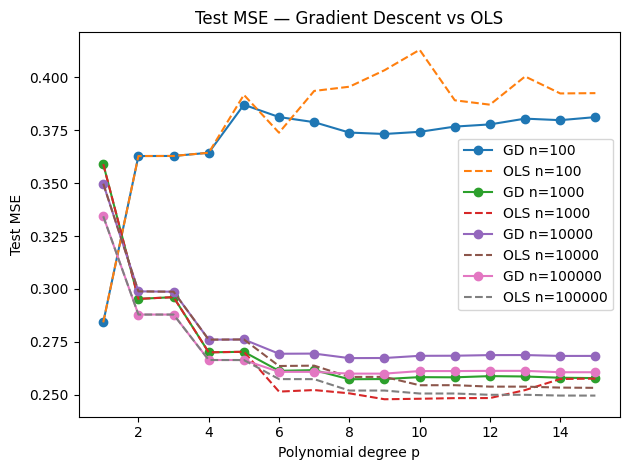

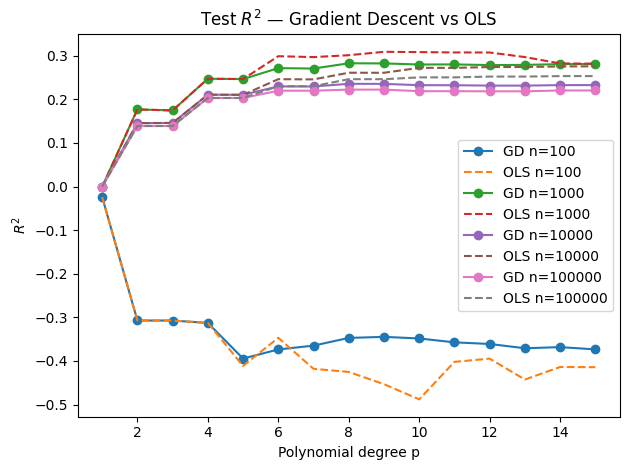

In [35]:
#kode for plotting fra chatgpt 

# Sammenlign Test MSE for GD vs OLS
ns = sorted({n for (n, _) in results_gd_ols.keys()})
plt.figure()
for n_focus in ns:
    ps = sorted({p for (n_key, p) in results_gd_ols.keys() if n_key == n_focus})
    
    mse_te_gd = [results_gd_ols[(n_focus, p)]["mse_test"] for p in ps]
    mse_te_ols = [results_ols[(n_focus, p)]["mse_test"] for p in ps]
    
    plt.plot(ps, mse_te_gd, marker="o", label=f"GD n={n_focus}")
    plt.plot(ps, mse_te_ols, linestyle="--", label=f"OLS n={n_focus}")
    
plt.title("Test MSE — Gradient Descent vs OLS")
plt.xlabel("Polynomial degree p")
plt.ylabel("Test MSE")
plt.legend()
plt.tight_layout()
plt.show()

# Eksempel for R^2 test
plt.figure()
for n_focus in ns:
    ps = sorted({p for (n_key, p) in results_gd_ols.keys() if n_key == n_focus})
    
    r2_te_gd = [results_gd_ols[(n_focus, p)]["R2_test"] for p in ps]
    r2_te_ols = [results_ols[(n_focus, p)]["R2_test"] for p in ps]
    
    plt.plot(ps, r2_te_gd, marker="o", label=f"GD n={n_focus}")
    plt.plot(ps, r2_te_ols, linestyle="--", label=f"OLS n={n_focus}")
    
plt.title("Test $R^2$ — Gradient Descent vs OLS")
plt.xlabel("Polynomial degree p")
plt.ylabel("$R^2$")
plt.legend()
plt.tight_layout()
plt.show()

In [37]:
# Ridge

results_gd_ridge = {}

rng = np.random.default_rng(73) #random number generator med random seed = 73

for n in datapoints:
    
    x = np.linspace(-1,1,n)
    y = 1 / (1 + 25*x**2)
    #noise = 0.5 * np.random.randn(n)    # Gaussian (normal distribution) noise
    #y = y + noise

    noise = 0.5 * rng.standard_normal(n)

    y = y + noise 

    #Make one index-split per n, and reuse for all p
    idx = np.arange(n)
    idx_train, idx_test = train_test_split(idx, test_size=0.2, random_state=73)


    for p in poly:
        
        Xp = polynomial_features(x, p, intercept=False)

        #use the same indexes for Xp and y
        X_train = Xp[idx_train, :]
        X_test = Xp[idx_test, :]
        y_train = y[idx_train]
        y_test = y[idx_test]

        #scale only on train, and then use the same scaler for test 
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train_s = scaler.transform(X_train)
        X_test_s = scaler.transform(X_test)

        #center y with train mean (and same offset on test)
        y_offset = np.mean(y_train)
        y_train_s = y_train - y_offset
        y_test_s = y_test - y_offset

            #for eta in etas:

        # Gradient descent loop

        theta_gd_ridge = np.zeros(X_train_s.shape[1])

        for t in range(num_iters):
            # Compute gradients for ridge
            grad_Ridge = (2 / len(y_train_s)) * (X_train_s.T @ (X_train_s @ theta_gd_ridge - y_train_s)) + 2 * lam * theta_gd_ridge

            # Update parameters theta
            theta_gd_ridge = theta_gd_ridge - eta * grad_Ridge

            #predicting y with the model (with sentered y)
            y_hat_train_sc = X_train_s @ theta_gd_ridge
            y_hat_test_sc = X_test_s @ theta_gd_ridge

            #unnormalising y - to be on the same scale as the original y values 
            #y_hat_train = y_hat_train_sc + y_offset
            #y_hat_test = y_hat_test_sc + y_offset

            #calculate MSE 
            mse_train = np.mean((y_train_s - y_hat_train_sc)**2)
            mse_test = np.mean((y_test_s - y_hat_test_sc)**2)

            #calculate R^2
            SSE_tr = np.sum((y_train_s - y_hat_train_sc)**2)
            SST_tr = np.sum((y_train_s - y_train_s.mean())**2)
            #SST_tr = np.sum(y_train_s**2)
            R2_train = 1 - SSE_tr / SST_tr

            SSE_te = np.sum((y_test_s - y_hat_test_sc)**2)
            SST_te = np.sum((y_test_s - y_train_s.mean())**2)
            #SST_te = np.sum(y_test_s**2)
            R2_test = 1 - SSE_te / SST_te

         # ---------- LAGRE PER (n, p, modell, lam) ----------
        key = (n, p, "ridge", float(lam))
        results_gd_ridge[key] = {
            "theta": theta_gd_ridge,
            "theta_norm": theta_norm,
            "mse_train": mse_train, "mse_test": mse_test,
            "R2_train": R2_train,   "R2_test": R2_test,
            "lam": float(lam), "reg_label": "ridge",
            "scaler_mean": scaler.mean_, "scaler_scale": scaler.scale_,
            "y_offset": y_offset,
            "idx_train": idx_train, "idx_test": idx_test,
            "x_train": x[idx_train], "x_test": x[idx_test],
        }
"""
        results_gd_ridge[(n, p)] = {
            #train, test, scaler values
            "X_train": X_train_s, "X_test": X_test_s,
            "y_train": y_train_s, "y_test": y_test_s,
            "scaler_mean": scaler.mean_, "scaler_scale": scaler.scale_,
            "y_offset": y_offset,
            #index and x values
            "idx_train": idx_train, "idx_test": idx_test,
            "x_train": x[idx_train], "x_test": x[idx_test],
            #theta, mse and R^2 values
            "theta": theta_gd_ridge, 
            "mse_train": mse_train, "mse_test": mse_test,
            "R2_train": R2_train, "R2_test": R2_test, 
        }
"""

'\n        results_gd_ridge[(n, p)] = {\n            #train, test, scaler values\n            "X_train": X_train_s, "X_test": X_test_s,\n            "y_train": y_train_s, "y_test": y_test_s,\n            "scaler_mean": scaler.mean_, "scaler_scale": scaler.scale_,\n            "y_offset": y_offset,\n            #index and x values\n            "idx_train": idx_train, "idx_test": idx_test,\n            "x_train": x[idx_train], "x_test": x[idx_test],\n            #theta, mse and R^2 values\n            "theta": theta_gd_ridge, \n            "mse_train": mse_train, "mse_test": mse_test,\n            "R2_train": R2_train, "R2_test": R2_test, \n        }\n'

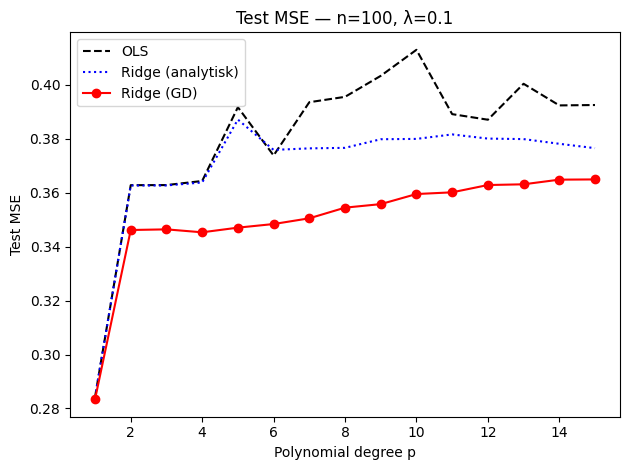

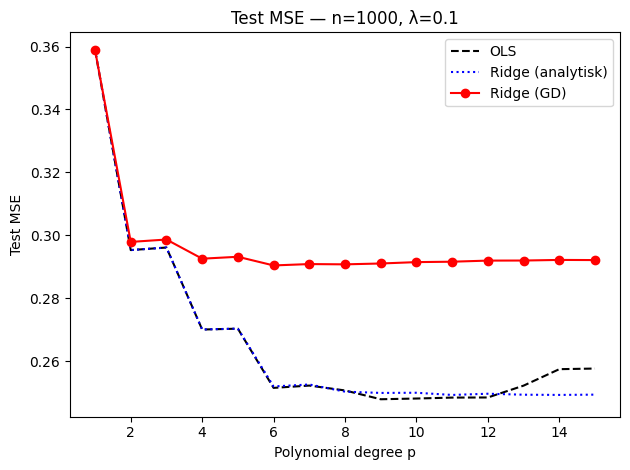

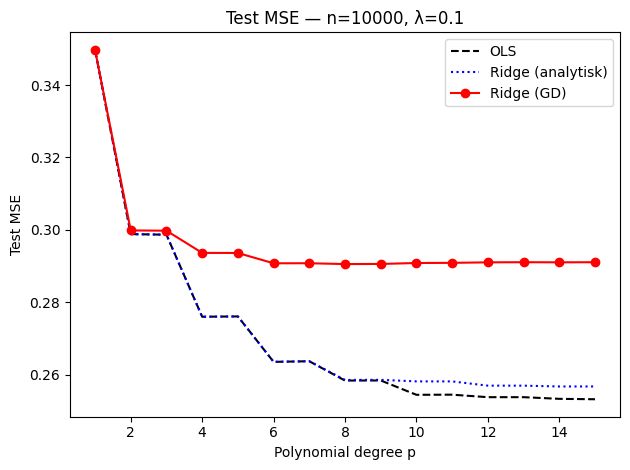

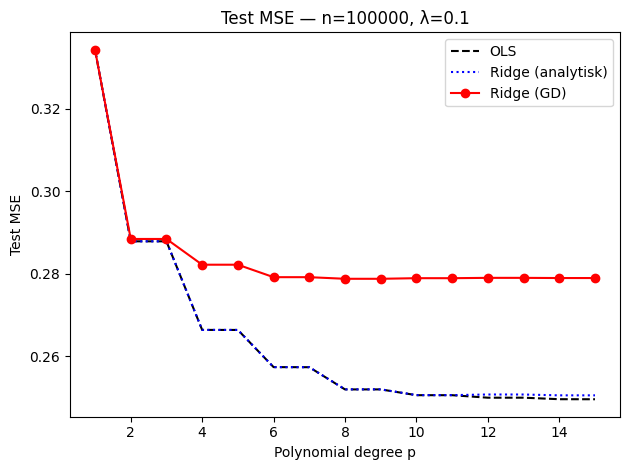

In [43]:
for n_focus in ns:
    plt.figure()
    ps = sorted({p for (n_key, p) in results_ols.keys() if n_key == n_focus})

    mse_te_ols = [results_ols[(n_focus, p)]["mse_test"] for p in ps]
    plt.plot(ps, mse_te_ols, "--", color="black", label="OLS")

    mse_te_ridge = []
    for p in ps:
        lam_match = nearest_lambda(lam, n_focus, p)
        mse_te_ridge.append(results_ridge[(n_focus, p, "ridge", lam_match)]["mse_test"])
    plt.plot(ps, mse_te_ridge, ":", color="blue", label="Ridge (analytisk)")

    mse_te_gd = [results_gd_ridge[(n_focus, p, "ridge", float(lam))]["mse_test"] for p in ps]
    plt.plot(ps, mse_te_gd, "o-", color="red", label="Ridge (GD)")

    plt.title(f"Test MSE — n={n_focus}, λ={lam}")
    plt.xlabel("Polynomial degree p")
    plt.ylabel("Test MSE")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()


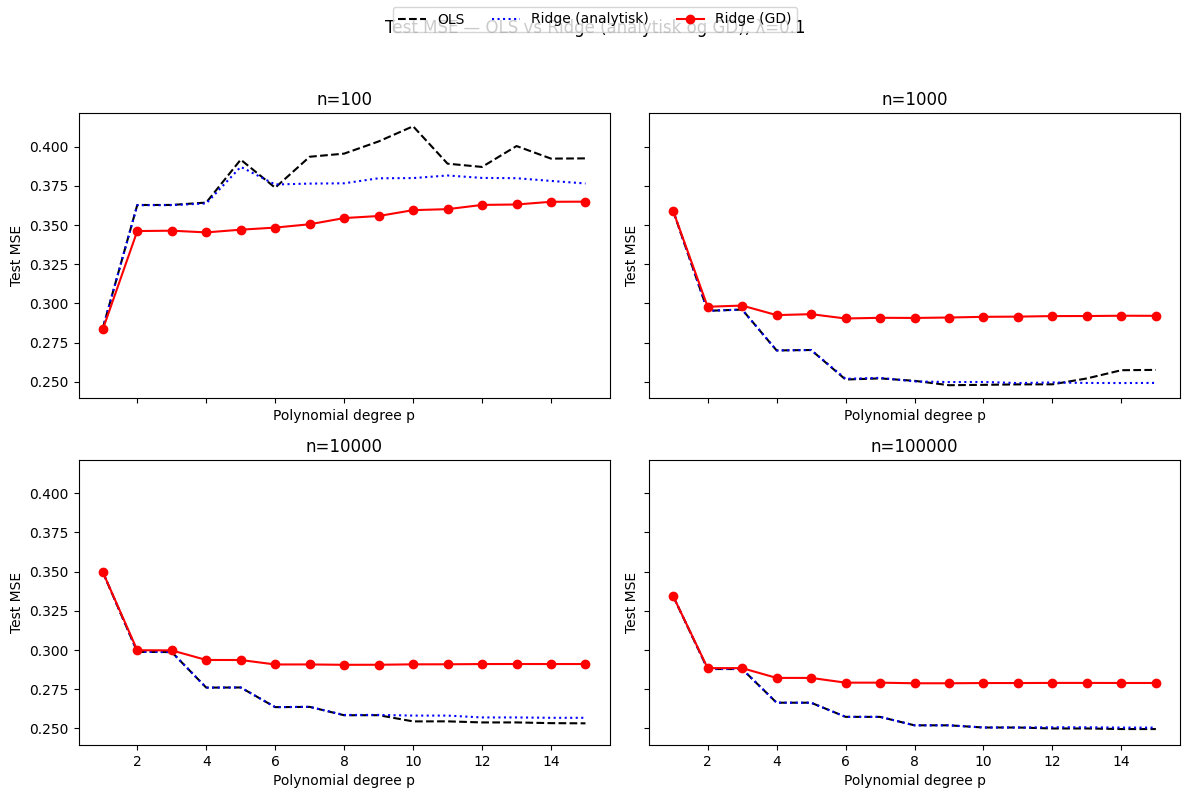

In [44]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)

for ax, n_focus in zip(axes.ravel(), ns):
    ps = sorted({p for (n_key, p) in results_ols.keys() if n_key == n_focus})

    mse_te_ols = [results_ols[(n_focus, p)]["mse_test"] for p in ps]
    ax.plot(ps, mse_te_ols, "--", color="black", label="OLS")

    mse_te_ridge = []
    for p in ps:
        lam_match = nearest_lambda(lam, n_focus, p)
        mse_te_ridge.append(results_ridge[(n_focus, p, "ridge", lam_match)]["mse_test"])
    ax.plot(ps, mse_te_ridge, ":", color="blue", label="Ridge (analytisk)")

    mse_te_gd = [results_gd_ridge[(n_focus, p, "ridge", float(lam))]["mse_test"] for p in ps]
    ax.plot(ps, mse_te_gd, "o-", color="red", label="Ridge (GD)")

    ax.set_title(f"n={n_focus}")
    ax.set_xlabel("Polynomial degree p")
    ax.set_ylabel("Test MSE")

# Felles legend
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=3)
fig.suptitle(f"Test MSE — OLS vs Ridge (analytisk og GD), λ={lam}")
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()


$\textbf{Part d: Including momentum and more advanced ways to update the learning the rate}$

In [ ]:
def gradient_descent(X, y, eta=0.01, num_iters=1000, lam=0.0, method="vanilla"):
    n, p = X.shape
    theta = np.zeros(p)
    eps = 1e-8

    # init tilleggsvariabler
    v = np.zeros(p)        # for momentum
    G = np.zeros(p)        # for AdaGrad
    Eg2 = np.zeros(p)      # for RMSprop
    m = np.zeros(p)        # for Adam
    v_hat = np.zeros(p)    # for Adam

    beta = 0.9
    beta1, beta2 = 0.9, 0.999

    hist = {"iter": [], "mse_train": []}

    for t in range(1, num_iters+1):
        grad = (2/n) * (X.T @ (X @ theta - y)) + 2*lam*theta

        if method == "vanilla":   # vanlig GD
            theta -= eta * grad

        elif method == "momentum":
            v = beta*v + eta*grad
            theta -= v

        elif method == "adagrad":
            G += grad**2
            theta -= (eta / (np.sqrt(G)+eps)) * grad

        elif method == "rmsprop":
            Eg2 = beta*Eg2 + (1-beta)*grad**2
            theta -= (eta / (np.sqrt(Eg2)+eps)) * grad

        elif method == "adam":
            m = beta1*m + (1-beta1)*grad
            v_hat = beta2*v_hat + (1-beta2)*(grad**2)
            m_corr = m / (1-beta1**t)
            v_corr = v_hat / (1-beta2**t)
            theta -= (eta / (np.sqrt(v_corr)+eps)) * m_corr

        # logg MSE underveis (valgfritt)
        if t % 10 == 0:
            mse_train = np.mean((y - X@theta)**2)
            hist["iter"].append(t)
            hist["mse_train"].append(mse_train)

    return theta, hist


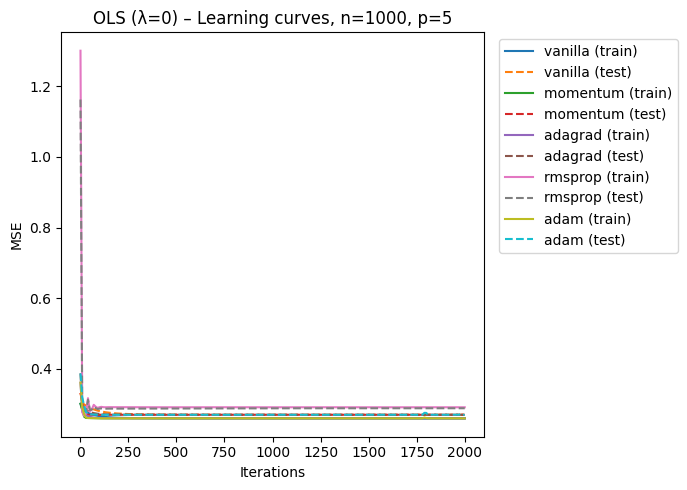

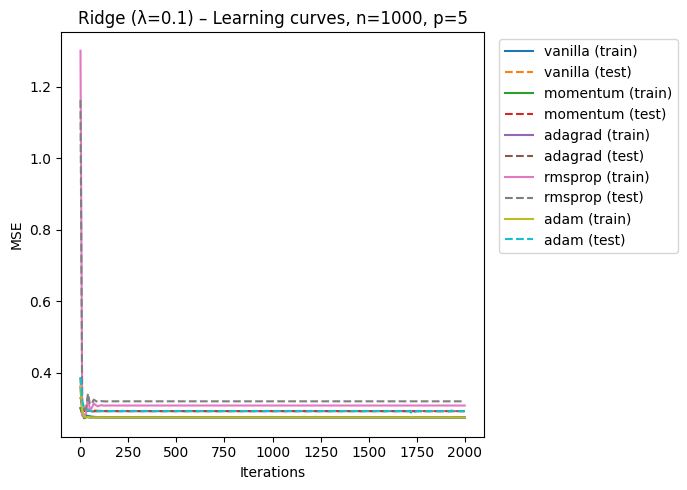

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# ----- Velg case -----
n_pick, p_pick = 1000, 5         # endre hvis du vil se andre
lam_ridge = 0.1                  # ridge-λ i del d
eta = 0.1                        # base lr
num_iters = 2000
eps = 1e-8

# Hent ferdigskalert data fra results_ols (din del a lagrer X_train/X_test/y_train/y_test senter/skalert)
Xtr = results_ols[(n_pick, p_pick)]["X_train"]
Xte = results_ols[(n_pick, p_pick)]["X_test"]
ytr = results_ols[(n_pick, p_pick)]["y_train"]
yte = results_ols[(n_pick, p_pick)]["y_test"]

def gd_run(X, y, X_val, y_val, eta=0.1, num_iters=2000, lam=0.0, method="vanilla",
           beta=0.9, beta1=0.9, beta2=0.999, eps=1e-8):
    n, p = X.shape
    theta = np.zeros(p)

    # Buffere for ulike metoder
    v = np.zeros(p)      # momentum
    G = np.zeros(p)      # AdaGrad (akkumulert grad^2)
    Eg2 = np.zeros(p)    # RMSprop (EMA av grad^2)
    m = np.zeros(p)      # Adam m_t
    v_adam = np.zeros(p) # Adam v_t

    hist = {"iter": [], "mse_train": [], "mse_test": []}

    for t in range(1, num_iters+1):
        # felles gradient for OLS/Ridge (på skalert X og senterert y)
        grad = (2.0/n) * (X.T @ (X @ theta - y)) + 2.0 * lam * theta

        if method == "vanilla":
            theta -= eta * grad

        elif method == "momentum":
            v = beta * v + eta * grad
            theta -= v

        elif method == "adagrad":
            G += grad**2
            theta -= (eta / (np.sqrt(G) + eps)) * grad

        elif method == "rmsprop":
            Eg2 = beta * Eg2 + (1.0 - beta) * (grad**2)
            theta -= (eta / (np.sqrt(Eg2) + eps)) * grad

        elif method == "adam":
            m = beta1 * m + (1.0 - beta1) * grad
            v_adam = beta2 * v_adam + (1.0 - beta2) * (grad**2)
            m_hat = m / (1.0 - beta1**t)
            v_hat = v_adam / (1.0 - beta2**t)
            theta -= (eta / (np.sqrt(v_hat) + eps)) * m_hat

        # logg (hver 10. iterasjon for ryddigere kurver)
        if t % 10 == 0 or t == 1 or t == num_iters:
            tr_pred = X @ theta
            te_pred = X_val @ theta
            mse_tr = np.mean((y - tr_pred)**2)
            mse_te = np.mean((y_val - te_pred)**2)
            hist["iter"].append(t)
            hist["mse_train"].append(mse_tr)
            hist["mse_test"].append(mse_te)

    return theta, hist

methods = ["vanilla", "momentum", "adagrad", "rmsprop", "adam"]

# ----- Kjør OLS (λ=0) -----
hists_ols = {}
for m in methods:
    _, h = gd_run(Xtr, ytr, Xte, yte, eta=eta, num_iters=num_iters, lam=0.0, method=m)
    hists_ols[m] = h

# ----- Kjør Ridge (λ=lam_ridge) -----
hists_ridge = {}
for m in methods:
    _, h = gd_run(Xtr, ytr, Xte, yte, eta=eta, num_iters=num_iters, lam=lam_ridge, method=m)
    hists_ridge[m] = h

# ----- Plot: OLS læringskurver -----
plt.figure(figsize=(7,5))
for m in methods:
    plt.plot(hists_ols[m]["iter"], hists_ols[m]["mse_train"], label=f"{m} (train)")
    plt.plot(hists_ols[m]["iter"], hists_ols[m]["mse_test"], linestyle="--", label=f"{m} (test)")
plt.title(f"OLS (λ=0) – Learning curves, n={n_pick}, p={p_pick}")
plt.xlabel("Iterations"); plt.ylabel("MSE")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left"); plt.tight_layout()
plt.show()

# ----- Plot: Ridge læringskurver -----
plt.figure(figsize=(7,5))
for m in methods:
    plt.plot(hists_ridge[m]["iter"], hists_ridge[m]["mse_train"], label=f"{m} (train)")
    plt.plot(hists_ridge[m]["iter"], hists_ridge[m]["mse_test"], linestyle="--", label=f"{m} (test)")
plt.title(f"Ridge (λ={lam_ridge}) – Learning curves, n={n_pick}, p={p_pick}")
plt.xlabel("Iterations"); plt.ylabel("MSE")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left"); plt.tight_layout()
plt.show()


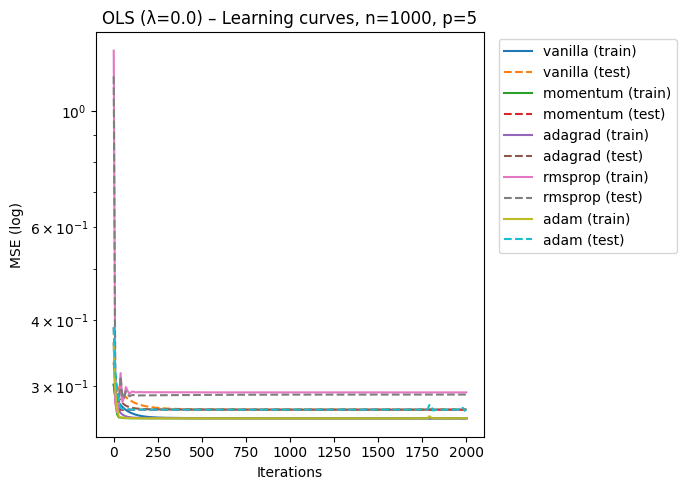

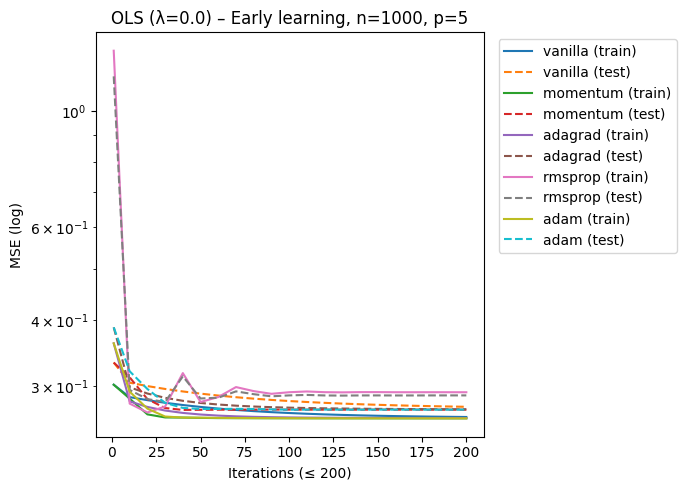

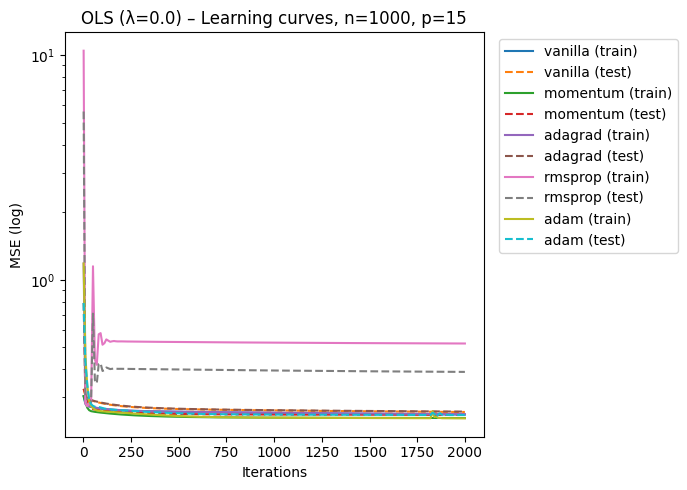

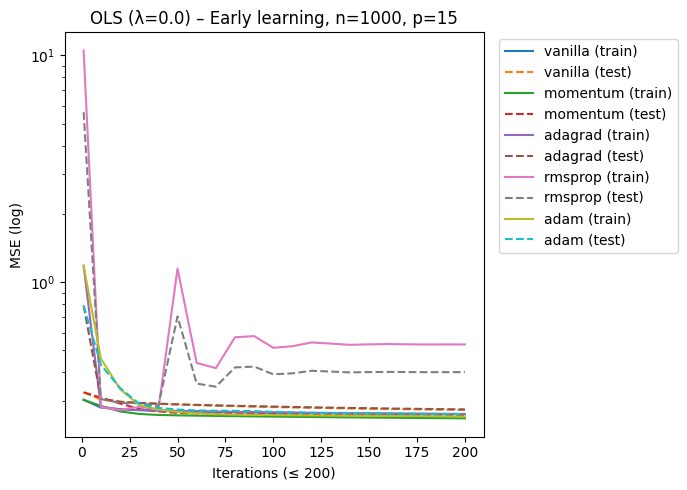

In [46]:
eta = 0.1
num_iters = 2000
methods = ["vanilla", "momentum", "adagrad", "rmsprop", "adam"]

def run_and_plot_learning_curves(n_pick, p_pick, lam_val=0.0, title_prefix="OLS"):
    # Hent skalert X/y fra results_ols
    Xtr = results_ols[(n_pick, p_pick)]["X_train"]
    Xte = results_ols[(n_pick, p_pick)]["X_test"]
    ytr = results_ols[(n_pick, p_pick)]["y_train"]
    yte = results_ols[(n_pick, p_pick)]["y_test"]

    # Tren alle metoder
    hists = {}
    for m in methods:
        _, h = gd_run(Xtr, ytr, Xte, yte, eta=eta, num_iters=num_iters, lam=lam_val, method=m)
        hists[m] = h

    # Plot log-skala (train og test)
    plt.figure(figsize=(7,5))
    for m in methods:
        plt.plot(hists[m]["iter"], hists[m]["mse_train"], label=f"{m} (train)")
        plt.plot(hists[m]["iter"], hists[m]["mse_test"], linestyle="--", label=f"{m} (test)")
    plt.yscale("log")
    plt.xlabel("Iterations"); plt.ylabel("MSE (log)")
    plt.title(f"{title_prefix} (λ={lam_val}) – Learning curves, n={n_pick}, p={p_pick}")
    plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

    # Zoom på tidlig fase (første 200 iterasjoner)
    plt.figure(figsize=(7,5))
    for m in methods:
        it = np.array(hists[m]["iter"])
        mtr = np.array(hists[m]["mse_train"])
        mte = np.array(hists[m]["mse_test"])
        mask = it <= 200
        plt.plot(it[mask], mtr[mask], label=f"{m} (train)")
        plt.plot(it[mask], mte[mask], linestyle="--", label=f"{m} (test)")
    plt.yscale("log")
    plt.xlabel("Iterations (≤ 200)"); plt.ylabel("MSE (log)")
    plt.title(f"{title_prefix} (λ={lam_val}) – Early learning, n={n_pick}, p={p_pick}")
    plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

# Kjør for p=5 og p=15 (samme n)
n_pick = 1000
run_and_plot_learning_curves(n_pick, p_pick=5,  lam_val=0.0, title_prefix="OLS")
run_and_plot_learning_curves(n_pick, p_pick=15, lam_val=0.0, title_prefix="OLS")


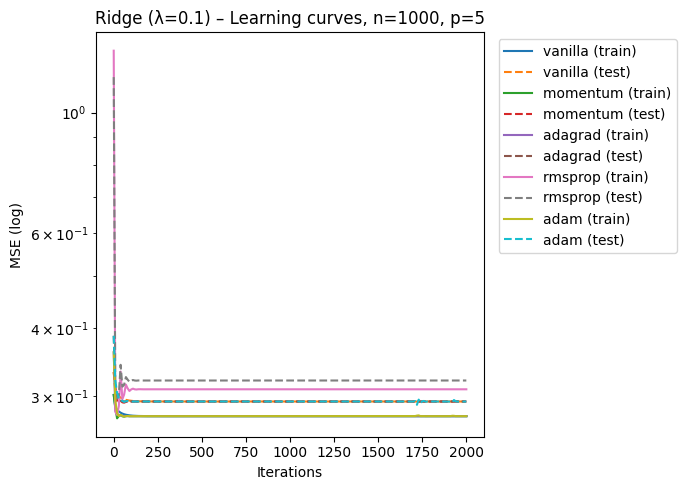

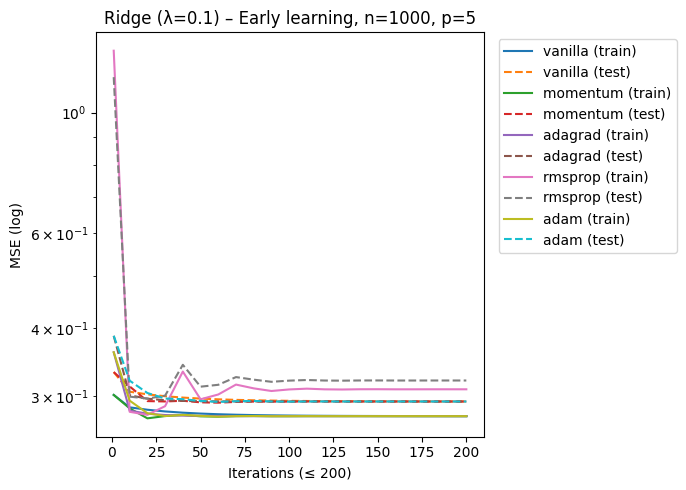

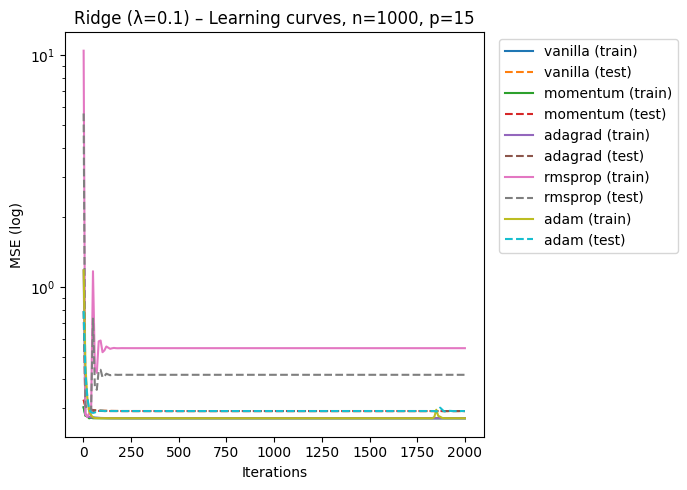

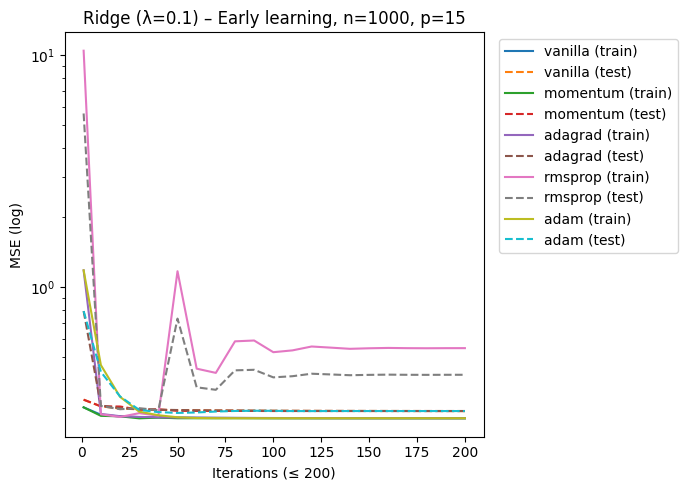

In [47]:
lam_ridge = 0.1
n_pick = 1000
run_and_plot_learning_curves(n_pick, p_pick=5,  lam_val=lam_ridge, title_prefix="Ridge")
run_and_plot_learning_curves(n_pick, p_pick=15, lam_val=lam_ridge, title_prefix="Ridge")
